In [24]:
key = '' #google api key
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps
# make sure this points to the file the data is to be saved in
dataDir = "data/dataAll"

In [17]:
# used to plot collected data points
def plotMap(polyGrid, Loc=[], restrict=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    if len(restrict)==0:
        restrict = list(polyGrid.keys())

    for k,v in polyGrid.items():
        if k in restrict:
            gPoly.append(gmaps.Polygon(
                            list(v),
                            stroke_color='red',
                            fill_color='blue'
                            ))
            sLoc.append((v[0][0],v[0][1]))
            sHtext.append(str(k))

    if len(Loc)!=0:
        sLoc = []
        sHtext = []
        for k,v in Loc.items():
            if k in restrict:
                sLoc += v
                sHtext += [str(k)+str(i) for i in v]

    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

246


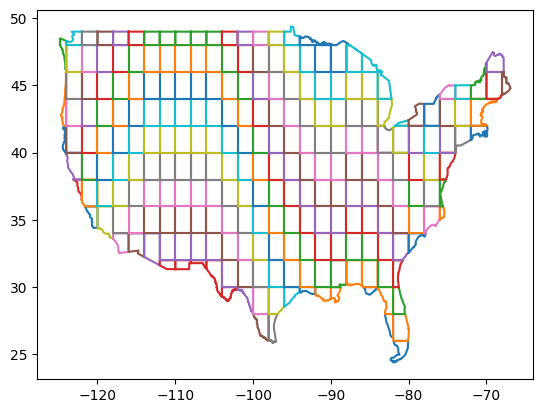

In [18]:
#Load list of polygons containing us map created in grid creation notebook
usaPolygonGrid = pickle.load(open("usaPolygonGrid.pkl",'rb'))
for i in usaPolygonGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolygonGrid))

In [19]:
plotMap(usaPolygonGrid, restrict=[0])

Figure(layout=FigureLayout(height='420px'))

# Google Streetview Image Scraping

We formed the grid using the grid generation noteook, and would like to restrict scraping of images  to areas within the grid.

In [20]:
searchGrids = usaPolygonGrid.keys()
# searchGrids = list(range(235,244))
print("Searching Grids: {}".format("All" if searchGrids==usaPolygonGrid.keys() else searchGrids))

Searching Grids: All


In [26]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Searching Grids: {}".format("All" if searchGrids==usaPolygonGrid.keys() else searchGrids))
for grid,coor in usaPolygonGrid.items():
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir + '/{}'.format(grid)
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        print("Save folder {}".format(saveFolder))
        print("Existing locations {}".format(locList))
        while count<20 and trials<10:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder + "/{}".format(location)
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)

                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, key)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print(locList)
        print("No duplicates: {}".format(len(locList)==len(set(locList))))
        print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Searching Grids: All
################## Searching grid 0 ###################
Save folder data/dataAll/0
Existing locations []
Trial: 1, count: 0
Valid location found: 40.18360141732506,-124.254074104279
Trial: 1, count: 1
Valid location found: 40.55581609244518,-124.0824412351569
Trial: 1, count: 2
Valid location found: 41.5292202974423,-124.058299646551
Trial: 1, count: 3
Valid location found: 40.79525463175639,-124.0299520760141
Trial: 1, count: 4
Valid location found: 40.75571239665786,-124.0372516366702
Trial: 1, count: 5
Failed trial 1 status or contains
Location 40.27635291668341,-124.00428814541493
Trial: 2, count: 5
Valid location found: 41.58632651641648,-124.0391341609504
Trial: 1, count: 6
Valid location found: 40.26341164506229,-124.1112743045353
Trial: 1, count: 7
Valid location found: 40.90248132441774,-124.0288321511949
Trial: 1, count: 8
Valid location found: 41.18803079852342,-124.1076959322542
Trial: 1, count: 9
Valid location found: 40.64320528563429,-124.29732212873